# Convert existing Tensorflow/Keras code to Ray AIR

If you already have working Tensorflow code, you don’t have to start from scratch to utilize the benefits of Ray AIR. Instead, you can continue to use your existing code and incrementally add Ray AIR components as needed.

Some of the benefits you’ll get by using Ray AIR with your existing Tensorflow training code:

- Easy distributed data-parallel training on a cluster
- Automatic checkpointing/fault tolerance and result tracking
- Parallel data preprocessing
- Seamless integration with hyperparameter tuning
- Scalable batch prediction
- Scalable model serving

This tutorial will show you how to start with Ray AIR from your existing Tensorflow training code. We will learn how to perform **distributed data-parallel training** and do **scalable batch prediction**.

## Example Code

The example code we’ll be using is that of the [Tensorflow quickstart tutorial](https://www.tensorflow.org/tutorials/quickstart/beginner). This code trains a neural network classifier on the MNIST dataset.

Follow along this example by launching the notebook using the 🚀 icon above!

## Existing Tensorflow Code

Let’s start with the unmodified code from the example. A thorough explanation of the parts is given in the full tutorial - we’ll just focus on the code here.

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


First, we load and preprocess the MNIST dataset.

Assumption for this tutorial: your existing code is using the `tf.data.Dataset` native to Tensorflow. This tutorial continues to use `tf.data.Dataset` to allow you to make as few code changes as possible. **Everything in this tutorial is also possible if you choose to use Ray Data, and you will also get the benefits of efficient preprocessing and multi-worker batch prediction.** See [here](train-datasets) for resources to get started with Ray Data.

In [23]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reserve 20% for validation, 80% for training
validation_split = 0.2
validation_size = int(validation_split * len(x_train))
x_valid, y_valid = x_train[-validation_size:], y_train[-validation_size:]
x_train, y_train = x_train[:-validation_size], y_train[:-validation_size]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(len(x_train)).batch(32)
valid_ds = tf.data.Dataset.from_tensor_slices(
    (x_valid, y_valid)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

print(f"Training Dataset: {len(x_train)} samples")
print(f"Validation Dataset: {len(x_valid)} samples")
print(f"Test Dataset: {len(x_test)} samples")

Training Dataset: 48000 samples
Validation Dataset: 12000 samples
Test Dataset: 10000 samples


Next, we define the model architecture of the neural network. We wrap the model definition inside a function for easy reuse later.

In [4]:
def build_model() -> tf.keras.Model:
    return tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10),
        ]
    )

Next, initialize the model, loss, optimizer, and define some metrics that we want to track during training.

We recommend using the Keras `Model.fit` API, as it simplifies distributing your training with `tf.distribute` and Ray AIR. Compile your model with a loss function and optimizer, then run `model.fit(train_ds)`.

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

model = build_model()
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=["accuracy"],
)

Lastly, we have the training loop, which trains the model for some number of epochs. Each epoch will loop through the entire training dataset and perform gradient descent steps.

One slight difference between the Tensorflow tutorial and this training loop is that we choose to train one epoch at a time rather than specifying multiple epochs through `model.fit(..., epochs=epochs)`. This will allow us to perform per epoch checkpointing and reporting.

In [6]:
epochs = 5

for epoch in range(epochs):
    # Fit the model for one epoch and evaluate on a validation set
    train_history = model.fit(train_ds, validation_data=valid_ds, verbose=0)

    # Pull the training and validation metrics
    train_result = {
        key: val[0] for key, val in train_history.history.items()
    }
    train_loss = train_result["loss"]
    train_accuracy = train_result["accuracy"]
    val_loss = train_result["val_loss"]
    val_accuracy = train_result["val_accuracy"]
    
    # Print out the metrics
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss:.4f}, '
        f'Accuracy: {train_accuracy * 100:.4f}, '
        f'Validation Loss: {val_loss:.4f}, '
        f'Validation Accuracy: {val_accuracy * 100:.4f}'
    )

# Evaluate on the test set and report metrics
eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
test_loss = eval_result["loss"]
test_accuracy = eval_result["accuracy"]
print(
    f"Final Test Loss: {test_loss:.4f}, "
    f"Final Test Accuracy: {test_accuracy:.4f}"
)

Epoch 1, Loss: 0.3297, Accuracy: 90.3229, Validation Loss: 0.1765, Validation Accuracy: 94.8583
Epoch 2, Loss: 0.1553, Accuracy: 95.3646, Validation Loss: 0.1187, Validation Accuracy: 96.4583
Epoch 3, Loss: 0.1149, Accuracy: 96.6125, Validation Loss: 0.1054, Validation Accuracy: 96.7750
Epoch 4, Loss: 0.0926, Accuracy: 97.1062, Validation Loss: 0.0952, Validation Accuracy: 97.1250
Epoch 5, Loss: 0.0784, Accuracy: 97.5750, Validation Loss: 0.0815, Validation Accuracy: 97.5167
Final Test Loss: 0.0740, Final Test Accuracy: 0.9763


## Wrap everything in a training loop function

Later on, we might want to perform hyperparameter optimization and launch multiple training runs, so it is useful to wrap the training logic we have so far in a function. We also introduce a function to get the training and test datasets, which is used within the training function.

In [7]:
def get_train_valid_test_datasets(batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    valid_ds = tf.data.Dataset.from_tensor_slices(
        (x_valid, y_valid)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(
        (x_test, y_test)).batch(batch_size)

    return train_ds, valid_ds, test_ds

def train_func():
    epochs = 5
    batch_size = 32

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()

    model = build_model()
    model.compile(
        optimizer=optimizer,
        loss=loss_object,
        metrics=["accuracy"],
    )
    
    train_ds, valid_ds, test_ds = get_train_valid_test_datasets(batch_size)
    
    for epoch in range(epochs):
        train_history = model.fit(train_ds, validation_data=valid_ds, verbose=0)

        train_result = {
            key: val[0] for key, val in train_history.history.items()
        }
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]
        val_loss = train_result["val_loss"]
        val_accuracy = train_result["val_accuracy"]

        print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss:.4f}, '
            f'Accuracy: {train_accuracy * 100:.4f}, '
            f'Validation Loss: {val_loss:.4f}, '
            f'Validation Accuracy: {val_accuracy * 100:.4f}'
        )

    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    print(
        f"Final Test Loss: {test_loss:.4f}, "
        f"Final Test Accuracy: {test_accuracy:.4f}"
    )

## Introduce Ray AIR for Distributed Data-Parallel Training

Now that we have set up a training loop that runs on a single worker, let's use Ray AIR to implement **distributed training**, allowing us to train using any number of workers!

Ray Train, the model training library within Ray AIR, implements a `TensorflowTrainer` that allows you to do [distributed training with Tensorflow](https://www.tensorflow.org/guide/distributed_training) without needing to create and handle workers manually. Ray Train creates workers in a Ray cluster and configures the `TF_CONFIG` environment variable for you. This way, you can use simply use a strategy from `tf.distribute` to run your training loop across multiple workers in a distributed data-parallel fashion! Currently, the only multi-worker strategy that Train supports is [`tf.distribute.MultiWorkerMirroredStrategy`](https://www.tensorflow.org/guide/distributed_training#multiworkermirroredstrategy), which shards the dataset evenly across workers and synchronizes parameter updates so that workers share the same weights at all times.

Let's start by installing Ray and AIR modules if we haven't already:

In [ ]:
!pip install "ray[air]"

### Update the train function

As a first step, let's implement the following:

1. Add a `config` argument as an easy way to pass in hyperparameters such as `batch_size_per_worker` through Ray Train.
2. Set up the model to **communicate gradients and synchronize model weights** between workers under the `tf.distribute.MultiWorkerMirroredStrategy` strategy.
3. Enable data-parallel distributed training by **sharding the training data** (and test data) so that each worker only deals with a subset of the data.

We only need change a few lines of code:

```python
from ray.air import session

# 1. Add a `config` argument to the train function to pass in hyperparameters

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    # 2. Build and compile the model within tf.distribute strategy scope
    
    # Important: The strategy must be instantiated at the beginning
    # of the function, since the tf dataset that we load later needs
    # to be auto-sharded.
    # See https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
    # for more details.
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()

        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )
    
    # 3. Set a `global_batch_size` so that every worker gets the specified
    #    `batch_size_per_worker` regardless of the number of workers.
    #    This is needed because the datasets are sharded across workers.

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, valid_ds, test_ds = get_train_valid_test_datasets(global_batch_size)
    # ^ Even though we are loading the datasets the same way as before, the
    # TF dataset will automatically shard the datasets across workers,
    # according to the strategy.
    
    # ...
```

A few notes on the [`session` API](air-session-ref) introduced by Ray AIR:
- {meth}`session.get_world_size() <ray.air.session.get_world_size>` is a Ray AIR helper that gets the number of workers doing training.
- In the updated code below, we also use the helper {meth}`session.get_world_rank() <ray.air.session.get_world_rank>` to only print logs on the head worker node (with rank 0) so that the output isn't spammed by logs from all workers.
- We will also use the `session` to report metrics and save/load checkpoints later!

Let's see the updated training function after these additions:

In [8]:
from ray.air import session

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, valid_ds, test_ds = get_train_valid_test_datasets(batch_size_per_worker)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        # The number of samples is approximate, because is not always
        # a multiple of batch_size, so some batches could contain fewer than
        # `batch_size_per_worker` samples.
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# validation batches per worker = {len(valid_ds)} "
            f"(~{len(valid_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )
  
    
    for epoch in range(epochs):
        train_history = model.fit(
            train_ds,
            validation_data=valid_ds,
            verbose=(0 if session.get_world_rank() != 0 else 2),
        )

    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    if session.get_world_rank() == 0:
        print(
            f"Final Test Loss: {test_loss:.4f}, "
            f"Final Test Accuracy: {test_accuracy:.4f}"
        )

### Move data loading inside of the training function

One important detail is that we should not try to use loaded data from outside of the training function. If we try to reference the training data from outside the training function, Ray serializes it to make it accessible to the remote tasks (that may get executed on a remote node!), and it's not ideal to ship the data around the cluster unnecessarily. Instead, move the dataset loading part into the `train_func()`. This will download the data *to disk once per machine* and result in much more efficient data loading.

Let's update the `get_train_valid_test_datasets` method to load the MNIST dataset rather than use a reference from outside the train function.

In [9]:
def get_train_valid_test_datasets(batch_size):
    # NEW: Now, the dataset will be downloaded to disk once per machine
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    # Reserve 20% for validation, 80% for training
    validation_split = 0.2
    validation_size = int(validation_split * len(x_train))
    x_valid, y_valid = x_train[-validation_size:], y_train[-validation_size:]
    x_train, y_train = x_train[:-validation_size], y_train[:-validation_size]
    
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    valid_ds = tf.data.Dataset.from_tensor_slices(
        (x_valid, y_valid)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(
        (x_test, y_test)).batch(batch_size)
    return train_ds, valid_ds, test_ds

### Start training with `TensorflowTrainer`

Now, we’ll use Ray Train’s `TensorflowTrainer` to kick off the distributed training.

A few notes on the configs set below:
- `train_loop_config` sets the hyperparmameters passed into the training loop as the `config` parameter
- `scaling_config` configures **how many parallel workers to use**, the **resources required per worker**, and whether we want to **enable GPU training** or not.

See this [configuration guide](train-config) for more details on how to configure the trainer.

In [ ]:
from ray import air
from ray.train.tensorflow import TensorflowTrainer

num_workers = 2
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 4,
    },
    scaling_config=air.ScalingConfig(
        num_workers=num_workers,
        use_gpu=use_gpu,
    ),
)
# Uncomment below to launch the training job
# result = trainer.fit()

Great, this works 🎉! You’re now training your model in parallel. You could now scale this up to more nodes and workers on your Ray cluster.

Next, we should **enable checkpointing** to enable fault-tolerance and get access to the trained model afterwards.

### Enable checkpointing to retrieve the model

There are two recommended ways of enabling checkpointing in Ray AIR.

#### Method 1: Checkpointing with a Keras `Callback`

The first method is to pass in a Keras `Callback` which will perform AIR metric reporting and checkpointing for us after each epoch. The callback will automatically report metrics such as `loss` and `accuracy` that are specified when compiling the model.

```python
from ray.air import session
from ray.air.callbacks.keras import Callback

def train_func(config: dict):
    
    # ...
    
    # 1. Load the checkpoint if resuming the training run
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope():

        if session.get_checkpoint():
            tf_checkpoint: TensorflowCheckpoint = session.get_checkpoint()
            model = tf_checkpoint.get_model(model_definition=build_model)
        else:
            model = build_model()

    # 2. Create and use Keras Callback
    report_metrics_and_checkpoint_callback = Callback()

    for epoch in range(epochs):
        model.fit(
            ...,
            callbacks=[report_metrics_and_checkpoint_callback]
        )

        # ...
```

Let's see the callback usage in the updated code below:

In [11]:
from ray.air import session
from ray.train.tensorflow import TensorflowCheckpoint
from ray.air.callbacks.keras import Callback

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        # NEW: Checkpoint loading
        if session.get_checkpoint():
            tf_checkpoint: TensorflowCheckpoint = session.get_checkpoint()
            model = tf_checkpoint.get_model(model_definition=build_model)
        else:
            model = build_model()

        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, valid_ds, test_ds = get_train_valid_test_datasets(batch_size_per_worker)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# validation batches per worker = {len(valid_ds)} "
            f"(~{len(valid_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )

    # NEW: Let AIR's Keras Callback handle checkpointing and metric reporting.
    report_metrics_and_checkpoint_callback = Callback()
    for epoch in range(epochs):
        model.fit(
            train_ds,
            validation_data=valid_ds,
            callbacks=[report_metrics_and_checkpoint_callback],
            verbose=(0 if session.get_world_rank() != 0 else 2),
        )

    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    if session.get_world_rank() == 0:
        print(
            f"Final Test Loss: {test_loss:.4f}, "
            f"Final Test Accuracy: {test_accuracy:.4f}"
        )

#### Method 2: Checkpointing with `session.report`

Alternatively, we can use {meth}`session.report <ray.air.session.report>` to report metrics and save checkpoints. **We would prefer this if we wanted finer-grain control for reporting extra metrics and checkpoint data.**

- The **metrics** will be logged to the experiment directory and visible to experiment analysis dashboards such as Tensorboard, or immediately available to us from the training result (ex: `result.metrics` or `result.metrics_dataframe` for a pandas dataframe).
- The **checkpoints** will be saved to the experiment directory for later use, or immediately available to us from the training result (ex:  `result.checkpoint`).

Here's how we would add checkpoint loading and saving with the framework-specific checkpoint {class}`TensorflowCheckpoint <ray.train.tensorflow.tensorflow_checkpoint.TensorflowCheckpoint>`. See the linked references to see other ways to create Tensorflow checkpoints.

```python
from ray.air import session
from ray.train.tensorflow import TensorflowCheckpoint

def train_func(config: dict):

    # 1. Load the checkpoint if resuming the training run
    # (Same as above.)
    
    for epoch in range(epochs):
        # ...

        # 2. Report metrics to AIR and save a checkpoint every epoch
        metrics = { ... }
        checkpoint = TensorflowCheckpoint.from_model(model)
        session.report(metrics, checkpoint=checkpoint)
```

Let's see what this checkpointing method looks like in the latest code!

In [12]:
from ray.air import session
from ray.train.tensorflow import TensorflowCheckpoint

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        # NEW: Checkpoint loading
        if session.get_checkpoint():
            tf_checkpoint: TensorflowCheckpoint = session.get_checkpoint()
            model = tf_checkpoint.get_model(model_definition=build_model)
        else:
            model = build_model()

        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, valid_ds, test_ds = get_train_valid_test_datasets(batch_size_per_worker)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# validation batches per worker = {len(valid_ds)} "
            f"(~{len(valid_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )
  
    for epoch in range(epochs):
        train_history = model.fit(
            train_ds,
            validation_data=valid_ds,
            verbose=(0 if session.get_world_rank() != 0 else 2),
        )
        
        # NEW: Metric reporting and checkpoint saving
        metrics = {
            key: val[0] for key, val in train_history.history.items()
        }
        checkpoint = TensorflowCheckpoint.from_model(model)
        session.report(metrics, checkpoint=checkpoint)

    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    if session.get_world_rank() == 0:
        print(
            f"Final Test Loss: {test_loss:.4f}, "
            f"Final Test Accuracy: {test_accuracy:.4f}"
        )

#### Specify a `FailureConfig`

Now that we have enabled checkpointing, we can specify a {class}`FailureConfig <ray.air.config.FailureConfig>` that controls how many times we should retry training from the latest checkpoint. This allows for some amount of fault-tolerance if a training run errors (ex: because of an out-of-memory issue).

In [ ]:
import ray
from ray import air
from ray.train.tensorflow import TensorflowTrainer

num_workers = 2
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 4,
    },
    scaling_config=air.ScalingConfig(
        num_workers=num_workers,
        use_gpu=use_gpu,
    ),
    run_config=air.RunConfig(
        # NEW: Failure config for retry on training failure
        failure_config=air.FailureConfig(max_failures=2),
    ),
)
result = trainer.fit()

We can use the training `Result` output of `trainer.fit()` to view some reported metrics. See the {class}`Result <ray.air.result.Result>` documentation for a full list of what's available. Let's plot the training and validation loss vs. training iteration.

<AxesSubplot: xlabel='training_iteration'>

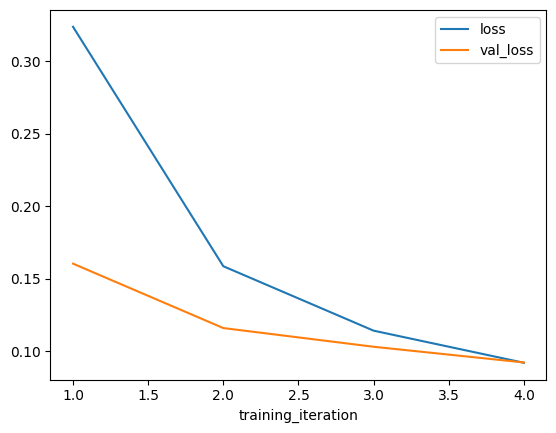

In [24]:
result.metrics_dataframe.plot("training_iteration", ["loss", "val_loss"])

## Using the trained model for prediction

The original Tensorflow quickstart tutorial doesn't actually go over loading the model for prediction, but let's see how you would complete the machine learning lifecycle with scalable batch prediction with Ray AIR!

### Loading the model for prediction

Here's how to load an [AIR Predictor](air-predictors) `TensorflowPredictor` from a checkpoint and perform model inference on some sample data.

In [15]:
from ray.train.tensorflow import TensorflowCheckpoint, TensorflowPredictor

tf_checkpoint: TensorflowCheckpoint = result.checkpoint
predictor = TensorflowPredictor.from_checkpoint(
    tf_checkpoint, model_definition=build_model
)

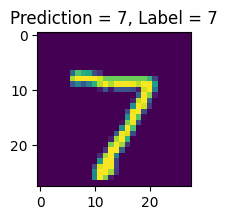

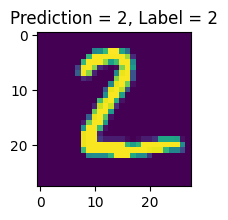

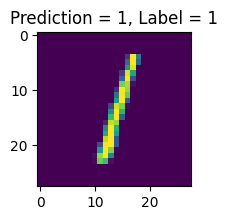

In [16]:
import matplotlib.pyplot as plt

sample_images = x_test[:3]
sample_labels = y_test[:3]
preds = predictor.predict(sample_images).argmax(1)
for image, pred, label in zip(sample_images, preds, sample_labels):
    plt.figure(figsize=(2, 2))
    plt.title(f"Prediction = {pred}, Label = {label}")
    plt.imshow(image.reshape((28, 28)))
    plt.show()

### Using Ray AIR for scalable batch prediction

Although what we did above works for a small amount of test data, we can use Ray AIR's {class}`BatchPredictor <ray.train.batch_predictor.BatchPredictor>` to do scalable prediction on a much larger dataset.

We can create a `BatchPredictor` from a checkpoint. We pass in the predictor class `TensorflowPredictor` and the `model_definition` of the checkpointed model.

In [17]:
import ray
from ray.train.batch_predictor import BatchPredictor
from ray.train.tensorflow import TensorflowPredictor

checkpoint: TensorflowCheckpoint = result.checkpoint

batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint,
    TensorflowPredictor,
    # A function that returns the model architecture
    model_definition=build_model,
)

Batch predictors work with [Ray Datasets](datasets). Here, we create a {class}`Dataset <ray.data.Dataset>` of images from our test set.

In [18]:
test_images_ds = ray.data.from_items(x_test)

Let's run {meth}`BatchPredictor.predict <ray.train.batch_predictor.BatchPredictor.predict>` on our Ray Dataset. This will distribute the prediction across a specified number of workers!

In [ ]:
predict_results = batch_predictor.predict(test_images_ds)

`predict_results` is also a Ray Dataset, and we can take a look at the predictions inside:

In [ ]:
predict_results.show()

```
{'predictions': array([ -2.5820212,  -5.676518 ,   2.0977738,   3.0335152,  -6.936249 ,
        -2.4465032, -12.235596 ,   9.626698 ,  -2.7761698,  -1.363163 ],
      dtype=float32)}
{'predictions': array([ -2.6007364,   6.3847456,  11.046391 ,   4.3116417, -12.745696 ,
         1.6003606,  -2.794311 ,  -6.191238 ,   2.4532976,  -9.940281 ],
      dtype=float32)}
...
```

Our model outputs logits, but we want the actual predicted labels. We can convert the logits to labels by taking the `argmax` of each model output in `predict_results` using {meth}`map_batches <ray.data.Dataset.map_batches>`. Then, we can compute the accuracy by comparing to the test set labels!

In [21]:
predicted_classes = predict_results.map_batches(
    lambda batch: [pred.argmax(0) for pred in batch["predictions"]], 
    batch_format="pandas"
)
predicted_classes_np = predicted_classes.take_all()

pred_accuracy = (predicted_classes_np == y_test).astype(int).sum() / len(predicted_classes_np)
print("Prediction Accuracy =", pred_accuracy)

Map_Batches: 100%|██████████| 3/3 [00:20<00:00,  6.88s/it]


Prediction Accuracy = 0.9723


(BlockWorker pid=314015) 2022-10-07 08:43:07.690997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(BlockWorker pid=314015) 2022-10-07 08:43:07.691049: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


## Summary

This tutorial demonstrated how a few lines of code with Ray AIR API's can allow you to scale up your Tensorflow model training.

We learned how to:
- enable distributed training using Ray Train abstractions
- save and retrieve model checkpoints via Ray AIR
- load a model for batch prediction

In our [other examples](air-examples-ref) you can learn how to do more things with the Ray AIR API, such as **serving your model with Ray Serve** or **tune your hyperparameters with Ray Tune**. You can also learn how to **construct Ray Datasets** to leverage Ray AIR’s **preprocessing** API.

See [this table](train-framework-catalog) for a full catalog of frameworks that AIR supports out of the box.

We hope this tutorial gave you a good starting point to leverage Ray AIR. If you have any questions, suggestions, or run into any problems pelase reach out on [Discuss](https://discuss.ray.io/), [GitHub](https://github.com/ray-project/ray) or the [Ray Slack](https://forms.gle/9TSdDYUgxYs8SA9e8)!